# Final Project - Final_Report.ipynb
Name: Bryce DiRisio

Class: CSCI349 - Intro to Data Mining

Semester: 2020sp

Instructor: Brian King

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from sklearn import datasets, linear_model, tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier

from scipy import stats

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Introduction

#### 1) What problem are you working on? Summarize in a single cell.

The dataset I am looking at involves information regarding wildlife trade. With this information, I am trying to gain a better sense of what factors go into trade. Part of this also involves finding identifying information that can help to locate and classify certain trades that occur.

#### 2) What modeling methods do you expect to use in your project?

For this dataset, I intend on utilizing the apriori algorithm first in order to find frequent patterns between 'importer' countries, 'exporter' countries, as well as the type of items they are trading. This would allow us isolate and examine places that have more significant trade around certain items and/or with other international countries. Secondly, I am looking to utilize a Keras neural network in order to see if we are able to model after transaction quantities based on what types of items are being traded. The logic behind this is that there may be potential factors affecting transaction quantities between certain items, such as item prices and ease of transport (i.e. easier to transport a bird feather vs a live elephant). 

#### 3) What is your overarching aim with this project? What are you hoping to learn? Or, what hypothesis are using the data to confirm or disprove? What challenges do you foresee on this project? Discuss your concerns. How will you get your work done? Give a reasonable list of milestones to reach to arrive at the final deadline for the project.

My overall aim with this project is to try and see where concentrated exchanges of wild animal products occur, as well as trying to deduce some method of trying to identify potential items being traded within interactions. While I could do this whole project focusing solely on the first objective, I did want to pursue a keras neural network of some sort in order to help hone my learning of applying machine learning skills. 

Looking into potential challenges within the project, I believe that one issue would be timeframe, considering that many classes are issuing finalized work/exams over our quarantine period. I'm expecting to spend a few days analyzing this dataset and applying my models, but my other concern is the mass amounts of data in my dataset (compared to what we've looked at before) may also take a significant amount of time to run and analyze, especially looking at hyperparameter performances where models are being analyzed multiple times and iterations. With this document done, I am hoping to spend around three whole days of time on the project: one day for completing apriori analysis, one day for working towards the keras objectives, and another day to finalize the final report. 

## Data

The .csv data file used for this project was retrieved from Kaggle: https://www.kaggle.com/cites/cites-wildlife-trade-database . The raw data contains transaction information for all legal wildlife trades reported towards the CITES (Convention on International Trade in Endangered Species of Wild Fauna and Flora) treaty from 2016, as well as a few datapoints in 2017 (filtered out in preprocessing later). The data was collected by form from importers and exporters in the transactions, so there are a few datapoints missing under some categories. Each observation represents a reported single wildlife item type transaction between two international communitites. For our classification model, we will be looking specifically at the 'Terms' category of the dataframe. Variable descriptions are as follows: 

'App.' (short for appendix) represents the Convention on Iternational Trade in Endangered Species of Wild Fauna and Flora (CITES) classification on species protection regulations. Species classified under 'Appendix I' have lots of protections and regulation in place, whereas 'Appendix III' species have the least regulations protecting them.

'Taxon' represents the genetic classification of the species being traded, and contains the genus and species for each animal in the transaction.

'Importer' represents the ISO 3166-1 alpha-2 letter code used to identify countries and dependent territories around the world, and tell us what country the transaction originates from 

'Exporter' represents the same ISO 3166-1 alpha-2 letter code used for the 'Importer' variable, and tell us what country the transaction is going to.

'Term' represents the specific item of the animal under the transaction, inclusive of live animals to animal products (hides, feathers, etc.). 

'Unit' represents the units for certain terms under ISO general standards. Some item in the 'Term' category require weight or volume specifications such as 'kilograms'.

'Purpose' describes what the need for the transaction is for/what the items in the transaction are used for. These reasons can range from breeding and educational use to personal hunting trophies. Each letter's meaning can be found on page 12 of this guide: https://trade.cites.org/cites_trade_guidelines/en-CITES_Trade_Database_Guide.pdf

'Source' represents how the species in question entered the market, whether it was from breeding, wild capture, or from a zoo.

'Quantity' represents the amount of items that were involved in the transaction, and goes with the 'Term' and 'Unit' columns in order to describe exactly what was being traded.

## Data Preparation

The following section focuses on cleaning the dataset from the kaggle website for this project. The line right below reads in .csv data from the 'data' folder of this project

In [2]:
#READING FUNCTION
df_raw = pd.read_csv('data\\wildlife_data_raw.csv')

The lines below convert our categorical variable from the 'object' type to the 'category' type. This done in order to save memory space from using this dataset, as well as allow our 'Term' variable to interact with the keras library. 

In [3]:
#CLEANING FUNCTIONS (see DataPrep_EDA.ipynb for explanations on code)
df_raw.loc[:,'App.'] = df_raw.loc[:,'App.'].astype('category')
df_raw.loc[:,'Taxon'] = df_raw.loc[:,'Taxon'].astype('category')
df_raw.loc[:,'Importer'] = df_raw.loc[:,'Importer'].astype('category')
df_raw.loc[:,'Exporter'] = df_raw.loc[:,'Exporter'].astype('category')
df_raw.loc[:,'Origin'] = df_raw.loc[:,'Origin'].astype('category')
df_raw.loc[:,'Term'] = df_raw.loc[:,'Term'].astype('category')
df_raw.loc[:,'Unit'] = df_raw.loc[:,'Unit'].astype('category')
df_raw.loc[:,'Purpose'] = df_raw.loc[:,'Purpose'].astype('category')
df_raw.loc[:,'Source'] = df_raw.loc[:,'Source'].astype('category')

The following line makes sure that only observations from 2016 are present in our dataset. This is to ensure constant timeframe for our 'time' variable, and allows us to delete it in order to save on more memory space. Justification for this code is explained in DataPrep_EDA.ipynb.

In [4]:
df_raw = df_raw.iloc[0:67007]

Next, our cleaning function looks into 'importer' and 'exporter' columns and changes 'NaN' entries to have the value '0'. Then it gathers what indices are missing this information. As these columns are vital to our association rules method, and missing entries make up ~0.23% of our total data, we are choosing to omit these rows from our modelling data.

In [5]:
df_raw.iloc[:,7] = df_raw.iloc[:,7].cat.add_categories('0')
df_raw.iloc[:,7] = df_raw.iloc[:,7].fillna(value='0')
df_raw.iloc[:,8] = df_raw.iloc[:,8].cat.add_categories('0')
df_raw.iloc[:,8] = df_raw.iloc[:,8].fillna(value='0')
df_raw.iloc[:,15] = df_raw.iloc[:,15].cat.add_categories('0')
df_raw.iloc[:,15] = df_raw.iloc[:,15].fillna(value='0')
df_missing_imp_exp = pd.DataFrame([df_raw.iloc[i] for i in range(df_raw.shape[0]) if (df_raw.iloc[i,7]=='0' or df_raw.iloc[i,8]=='0')])
df_missing_source = pd.DataFrame([df_raw.iloc[i] for i in range(df_raw.shape[0]) if (df_raw.iloc[i,15]=='0')])
indices_ie = df_missing_imp_exp.index.values.tolist()
indices_s = df_missing_source.index.values.tolist()
indices = list(set().union(indices_ie,indices_s))
df_raw = df_raw.drop(indices)
df_raw = df_raw.reset_index(drop=True)

For the most challenging part of our data cleaning, we now have to deal with inconsistent 'quantity' measurements. In our dataframe there are two columns of interest: 'Importer reported quantity', and 'Exporter reported quantity'. Doing exploratory coding in our dataprep file, we found that for every observation, there was at least one number in one or both categories (i.e. no data rows present with both entries missing). For this, I decided that if observations only had one reported number for both categories (i.e. if one of them was marked as 'NaN'), then that number would be the quantity for that transaction. However, if both values were present, I would take the average of those two numbers and report that as the quantity. This way, observations with the same quantity reported kept their reported number, and observations with minor differences in the number would be reported in order to preserve the equal weight of both transaction parties.

However, this last averaging method was not applicable for all observations present that had two mismatched quantities. In some dataframe rows, reported quantities were VASTLY different from each other (ex: reporting 500 feathers exported and only 2 imported). While this discrepancy could happen for a number of reasons (theft, item breakage, etc.), it is impossible to distinguish certain scenarios from this dataframe. Thus, in order to limit the difference in these two numbers, I implemented a 'threshold' global variable to control the magnitude of difference between these two. That way, if an observation was out of my threshold range, then I theoretically would not be able to use its reported quantity in my classification model due to accuracy issues, and would have to discard the measurement. The threshold of 4 was generated so that only around 100 of my 65000+ observations in the dataframe would have to be removed, rather than a few thousand that had mismatched numbers for import and export quantities. 

In [6]:
df_two_quantities = pd.DataFrame([df_raw.iloc[i] for i in range(df_raw.shape[0]) if (~np.isnan(df_raw.iloc[i,10]) and (~np.isnan(df_raw.iloc[i,11])))])
pd.DataFrame([df_two_quantities.iloc[i] for i in range(df_two_quantities.shape[0]) if df_two_quantities.iloc[i,10] != df_two_quantities.iloc[i,11]])
THRESHOLD = 4 #4x difference in two quantities
df_to_remove = pd.DataFrame([df_two_quantities.iloc[i] for i in range(df_two_quantities.shape[0]) if (df_two_quantities.iloc[i,11]/df_two_quantities.iloc[i,10] > THRESHOLD) or (df_two_quantities.iloc[i,10]/df_two_quantities.iloc[i,11] > THRESHOLD)])
df_to_remove
indices = df_to_remove.index.values.tolist()
df_raw = df_raw.drop(indices)
df_raw = df_raw.reset_index(drop=True)
df_raw['Quantity'] = 0

#fill in quantities
for i in range(df_raw.shape[0]):
    if np.isnan(df_raw.iloc[i,10]):
        df_raw.iloc[i,16] = df_raw.iloc[i,11]
    elif np.isnan(df_raw.iloc[i,11]):
        df_raw.iloc[i,16] = df_raw.iloc[i,10]
    else:
        df_raw.iloc[i,16] = (df_raw.iloc[i,10] + df_raw.iloc[i,11])/2
        

For the last part of cleaning the dataframe, we drop unnecessary columns that are not under forcus for this project. This includes information that is repetitive (such as animal classification under 'Taxon') or trivial (such as the 'Year' column, since we know all transactions take place in 2016).

In [7]:
df_raw = df_raw.drop(labels = ['Importer reported quantity','Exporter reported quantity'],axis=1)
df_raw = df_raw.drop(labels = ['Class','Order','Family','Genus'],axis=1)
df_raw = df_raw.drop(labels = ['Origin','Year'],axis=1)

Finally, our dataframe is cleaned and ready for the model.

In [8]:
df_raw

App.                      Taxon Importer Exporter  \
0        I             Aquila heliaca       TR       NL   
1        I             Aquila heliaca       XV       RS   
2        I       Haliaeetus albicilla       BE       NO   
3        I       Haliaeetus albicilla       BE       NO   
4        I       Haliaeetus albicilla       DK       IS   
...    ...                        ...      ...      ...   
64896    N  Tribolonotus novaeguineae       DE       ID   
64897    N   Selaginella lepidophylla       DE       MX   
64898    N   Selaginella lepidophylla       DE       MX   
64899    N           Struthio camelus       RO       CH   
64900    N        Lamprotornis regius       DE       TZ   

                           Term Unit Purpose Source  Quantity  
0                        bodies  NaN       T      C       1.0  
1                        bodies  NaN       Q      O       1.0  
2                      feathers  NaN       S      W      43.0  
3                     specimens  NaN       S      W      43.0  
4                     specimens  NaN       S      W     700.0  
...                         ...  ...     ...    ...       ...  
64896                      live  NaN       T      U      20.0  
64897              dried plants   kg       T      W     162.3  
64898                    leaves   kg       T      W    5000.0  
64899  leather products (small)  NaN       T      C       1.0  
64900                      live  NaN       T      U      10.0  

[64901 rows x 9 columns]

## Visual EDA

Text(0.5, 1.0, 'Top Exporting Countries by Number of Transactions')

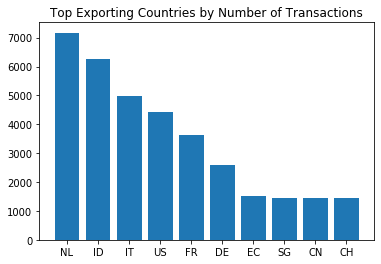

In [9]:
export_counts = df_raw.iloc[:,3].value_counts().head(10)
plt.bar(x=export_counts.index,height=export_counts)
plt.title("Top Exporting Countries by Number of Transactions")

Text(0.5, 1.0, 'Top Importing Countries by Number of Transactions')

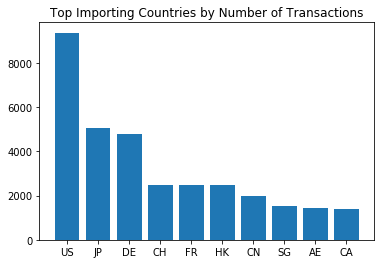

In [10]:
import_counts = df_raw.iloc[:,2].value_counts().head(10)
plt.bar(x=import_counts.index,height=import_counts)
plt.title("Top Importing Countries by Number of Transactions")

In [11]:
df_sort_type = df_raw.sort_values(by='Term')
term_values = df_sort_type.iloc[:,4].value_counts().head(3)
plt.bar(x=term_values.index,height=term_values)
plt.title("Top items Traded (by # of transactions)")

Text(0.5, 1.0, 'Top items Traded (by # of transactions)')

Text(0.5, 1.0, 'Boxplot of Term category values')

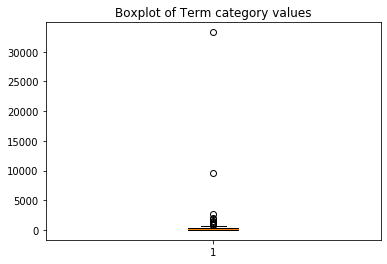

In [12]:
plt.boxplot(df_raw['Term'].value_counts())
plt.title('Boxplot of Term category values')

## Model 

### Apriori

For the Apriori frequent pattern mining, I ran three models to find patterns between three categories: 'Importer', 'Exporter', and 'Term'. While no frequent patterns were found between 'Importer' and 'Exporter' countries, these patterns did achieve results looking between the two country categories and the items they were trading.

Import country and import items:

In [13]:
df_data = df_raw.iloc[:,2:5]
df_data = df_data.drop('Exporter',axis=1)
list_data = df_data.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(list_data).transform(list_data)
df_import_te = pd.DataFrame(te_ary, columns=te.columns_)
df_import_te

AD     AE     AF     AG     AI     AL     AM     AN     AO     AR  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
64896  False  False  False  False  False  False  False  False  False  False   
64897  False  False  False  False  False  False  False  False  False  False   
64898  False  False  False  False  False  False  False  False  False  False   
64899  False  False  False  False  False  False  False  False  False  False   
64900  False  False  False  False  False  False  False  False  False  False   

       ...  tails  teeth  timber  trophies  trunk  tusks  unspecified  veneer  \
0      ...  False  False   False     False  False  False        False   False   
1      ...  False  False   False     False  False  False        False   False   
2      ...  False  False   False     False  False  False        False   False   
3      ...  False  False   False     False  False  False        False   False   
4      ...  False  False   False     False  False  False        False   False   
...    ...    ...    ...     ...       ...    ...    ...          ...     ...   
64896  ...  False  False   False     False  False  False        False   False   
64897  ...  False  False   False     False  False  False        False   False   
64898  ...  False  False   False     False  False  False        False   False   
64899  ...  False  False   False     False  False  False        False   False   
64900  ...  False  False   False     False  False  False        False   False   

         wax  wood product  
0      False         False  
1      False         False  
2      False         False  
3      False         False  
4      False         False  
...      ...           ...  
64896  False         False  
64897  False         False  
64898  False         False  
64899  False         False  
64900  False         False  

[64901 rows x 297 columns]

In [14]:
df_apriori_import = apriori(df_import_te,min_support=0.05,use_colnames=True)
df_apriori_import

support                    itemsets
0  0.073728                        (DE)
1  0.078057                        (JP)
2  0.144435                        (US)
3  0.148180  (leather products (small))
4  0.512658                      (live)
5  0.056717                  (DE, live)
6  0.050770                  (JP, live)
7  0.054391                  (US, live)

Export country and export items:

In [15]:
df_data = df_raw.iloc[:,2:5]
df_data = df_data.drop('Importer',axis=1)
list_data = df_data.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(list_data).transform(list_data)
df_export_te = pd.DataFrame(te_ary, columns=te.columns_)
df_export_te

AD     AE     AG     AL     AM     AN     AQ     AR     AT     AU  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
64896  False  False  False  False  False  False  False  False  False  False   
64897  False  False  False  False  False  False  False  False  False  False   
64898  False  False  False  False  False  False  False  False  False  False   
64899  False  False  False  False  False  False  False  False  False  False   
64900  False  False  False  False  False  False  False  False  False  False   

       ...  tails  teeth  timber  trophies  trunk  tusks  unspecified  veneer  \
0      ...  False  False   False     False  False  False        False   False   
1      ...  False  False   False     False  False  False        False   False   
2      ...  False  False   False     False  False  False        False   False   
3      ...  False  False   False     False  False  False        False   False   
4      ...  False  False   False     False  False  False        False   False   
...    ...    ...    ...     ...       ...    ...    ...          ...     ...   
64896  ...  False  False   False     False  False  False        False   False   
64897  ...  False  False   False     False  False  False        False   False   
64898  ...  False  False   False     False  False  False        False   False   
64899  ...  False  False   False     False  False  False        False   False   
64900  ...  False  False   False     False  False  False        False   False   

         wax  wood product  
0      False         False  
1      False         False  
2      False         False  
3      False         False  
4      False         False  
...      ...           ...  
64896  False         False  
64897  False         False  
64898  False         False  
64899  False         False  
64900  False         False  

[64901 rows x 290 columns]

In [16]:
df_apriori_export = apriori(df_export_te,min_support=0.05,use_colnames=True)
df_apriori_export

support                    itemsets
0  0.056039                        (FR)
1  0.096455                        (ID)
2  0.076701                        (IT)
3  0.110476                        (NL)
4  0.068319                        (US)
5  0.148180  (leather products (small))
6  0.512658                      (live)
7  0.077302                  (ID, live)
8  0.104498                  (live, NL)

### Classification

For the classification model, I used a keras neural network in order to analyze predicting trade quantities based on items present in the transaction. The immediate code organizes X (quantities) and y (item term) data to be used in the neural net.

In [17]:
X = df_raw.iloc[:,len(df_raw.columns)-1:] #numeric
y = df_raw.iloc[:,4] #categorical
X, y = shuffle(X, y)
X = stats.zscore(X)
y=pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=0)
y_train_binarized = pd.get_dummies(y_train)
y_test_binarized = pd.get_dummies(y_test)

The function below creates the keras model for the term characteristic. It uses an input shape of 1 to account for the single categorical variable, and an 83 output layer to account for each of the unique categories in the 'Term' column.

In [18]:
def create_keras_term_model(activation, optimizer, hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(1,)))
    model.add(Activation(activation))
    model.add(Dense(83))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

The code below is used to analyze different hyperparameters to use on the keras model, and optimize our keras values so that we can extract the maximum prediction accuracy.

In [19]:
param_grid = {
    'optimizer': ['adam','sgd'],
    'hidden_units': [5,10],
    'activation': ['relu','sigmoid','tan'],
    'epochs': [10,20],
    'batch_size': [4]
}

grid = GridSearchCV(KerasClassifier(build_fn=create_keras_term_model, verbose=0),
                    param_grid,
                    return_train_score=True,
                    cv=5,
                    refit=False,
                    n_jobs = 4, pre_dispatch=4)

grid_result = grid.fit(X,y)

#get data
df_results = pd.DataFrame(grid_result.cv_results_)

def get_results(dataFrame):

    #set up columns
    df_params = dataFrame.loc[:,'params']
    df_mean_training = dataFrame.loc[:,'mean_train_score']
    df_mean_testing = dataFrame.loc[:,'mean_test_score']
    df_std_train = dataFrame.loc[:,'std_train_score']
    df_std_test = dataFrame.loc[:,'std_test_score']

    #form final table
    df_final = pd.DataFrame()
    df_final['params']=df_params
    df_final['mean_training']=df_mean_training
    df_final['std_training']=df_std_train
    df_final['mean_testing']=df_mean_testing
    df_final['std_testing']=df_std_test
    return df_final.sort_values(by='mean_testing',ascending=False).head(5)


In [30]:
get_results(df_results).head(5).params

0     {'activation': 'relu', 'batch_size': 4, 'epoch...
3     {'activation': 'relu', 'batch_size': 4, 'epoch...
8     {'activation': 'sigmoid', 'batch_size': 4, 'ep...
9     {'activation': 'sigmoid', 'batch_size': 4, 'ep...
10    {'activation': 'sigmoid', 'batch_size': 4, 'ep...
Name: params, dtype: object

The code below compiles the final/most optimized model from the hyperparameteres in the step before.

In [20]:
model = create_keras_term_model(get_results(df_results).iloc[0,0]['activation'],get_results(df_results).iloc[0,0]['optimizer'],get_results(df_results).iloc[0,0]['hidden_units'])
history = model.fit(X_train, y_train_binarized, epochs=get_results(df_results).iloc[0,0]['epochs'], batch_size=get_results(df_results).iloc[0,0]['batch_size'], verbose=1, validation_data=(X_test, y_test_binarized))

Train on 32450 samples, validate on 32451 samples
Epoch 1/10
32450/32450 [==============================] - 11s 326us/step - loss: 2.2515 - accuracy: 0.5155 - val_loss: 2.1473 - val_accuracy: 0.5090
Epoch 2/10
32450/32450 [==============================] - 10s 308us/step - loss: 2.1326 - accuracy: 0.5163 - val_loss: 2.1470 - val_accuracy: 0.5090
Epoch 3/10
32450/32450 [==============================] - 10s 310us/step - loss: 2.1305 - accuracy: 0.5162 - val_loss: 2.1473 - val_accuracy: 0.5090
Epoch 4/10
32450/32450 [==============================] - 10s 322us/step - loss: 2.1295 - accuracy: 0.5162 - val_loss: 2.1479 - val_accuracy: 0.5090
Epoch 5/10
32450/32450 [==============================] - 10s 307us/step - loss: 2.1287 - accuracy: 0.5163 - val_loss: 2.1470 - val_accuracy: 0.5090
Epoch 6/10
32450/32450 [==============================] - 10s 318us/step - loss: 2.1283 - accuracy: 0.5162 - val_loss: 2.1484 - val_accuracy: 0.5090
Epoch 7/10
32450/32450 [==============================] 

## Performance Results

### Apriori

In [21]:
import_rules = association_rules(df_apriori_import, min_threshold = 0.05)
import_rules.sort_values(['confidence'],ascending = [False]).head(5)

antecedents consequents  antecedent support  consequent support   support  \
0        (DE)      (live)            0.073728            0.512658  0.056717   
2        (JP)      (live)            0.078057            0.512658  0.050770   
4        (US)      (live)            0.144435            0.512658  0.054391   
1      (live)        (DE)            0.512658            0.073728  0.056717   
5      (live)        (US)            0.512658            0.144435  0.054391   

   confidence      lift  leverage  conviction  
0    0.769279  1.500570  0.018920    2.112258  
2    0.650415  1.268711  0.010753    1.394058  
4    0.376574  0.734551 -0.019655    0.781716  
1    0.110634  1.500570  0.018920    1.041497  
5    0.106095  0.734551 -0.019655    0.957109

Looking at our strongest importing rule above, we see that the antecedent support is 0.073728. This tells us that around 7% of all reported international trades involve the DE country (Germany). For the consequent, the support value is 0.512658, signaling that around 51.2% of all reported international imports involve 'live' animals. Our support value for this transaction on a whole is 0.056717, so ~5.7% of all reported trades will involve Germany importing live animals. 
    
For confidence, our metric is 0.76928, telling us that if a transaction involves Germany imorting, 76.9% of them will contain live animals.
    
Finally, our lift metric is ~1.5. Since this is above 1.0, we can say that transactions with germany are more likely to contain live animals compared to the aggregate set of transactions.

In [22]:
export_rules = association_rules(df_apriori_export, min_threshold = 0.05)
export_rules.sort_values(['confidence'],ascending = [False]).head(5)

antecedents consequents  antecedent support  consequent support   support  \
3        (NL)      (live)            0.110476            0.512658  0.104498   
0        (ID)      (live)            0.096455            0.512658  0.077302   
2      (live)        (NL)            0.512658            0.110476  0.104498   
1      (live)        (ID)            0.512658            0.096455  0.077302   

   confidence      lift  leverage  conviction  
3    0.945886  1.845063  0.047861    9.005784  
0    0.801438  1.563300  0.027854    2.454354  
2    0.203835  1.845063  0.047861    1.117261  
1    0.150787  1.563300  0.027854    1.063980

Looking at our strongest exporting rule above, we see that the antecedent support is 0.1105. This tells us that around 11% of all reported international trades involve NL (the Netherlands). For the consequent, the support value is 0.513, signaling that around 51.3% of all reported international exports involve live animals. Our support value for this transaction on a whole is 0.1045 , so 10.45% of all reported trades will involve the Netherlands exporting live animals. 
    
For confidence, our metric is 0.946, telling us that if a transaction involves exporting from the Netherlands, 94.6% of them will contain live animals.
    
Finally, our lift metric is 1.845. This metric indicates that transactions involving the Netherlands exporting are more likely to contain live animals compared to the aggregate transaction set.

### Classification

In [23]:
def model_performance():
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #loss
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch Step')
    ax1.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()

    #accuracy
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch Step')
    ax2.legend(['Train', 'Test'], loc='upper left')

    plt.show()

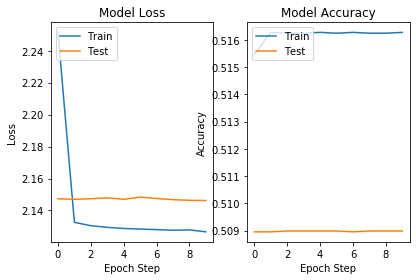

In [24]:
model_performance()

The graphs above show how the model performed for classifying trade items based on quantities. The final accuracy of the model was around 0.5163, which is pretty low and not performing too well relative to other models. 

Looking at model loss, we see that there is a training decrease as we increase our epoch. However, it does stagnate relatively high at around 2.12. This is also an indicator of a model not performing well. 

## Discussion

Looking back on the project, the longest part of this was definitely done with cleaning the data. On multiple occasions, I had to manually look into certain data rows to see how 'NaN' values were stored in the frame, or how to deal with the quantities columns for the dataframe. Not only that, but when modeling with the classification method was involved, hyperparameter tuning took a significant amount of time (2+ hours per run) due to the large size of the dataset. I am also surprise to see the prevalence of Netherlands and German trading with live animals, though given more time I'd like to analyze specific animals being traded, originating sources of these animals, and more. 

Finally, looking at our hyperparameters specifically, it seems that the relu activation function was able to perform slightly better compared to the sigmoid function for our keras model. 

## Conclusion

Looking at the data above, we can deduce from our frequent patterns that Germany and Netherlands are both countries heavily invested in the international live animal trade. Germany is a strong importer of live animals while the Netherlands is a strong exporter of them, each of them dedicating most of their transactions towards the trade. While I wasn't able to find conclusive results on predicting trade quantities based on item, this project did shed light into the international wildlife community and where certain items are going. 